In [28]:
import sys
sys.path.append('../')
from mainseq_corrections import niiha_oh_determine

import plot_mainseq_UV_Ha_comparison
reload(plot_mainseq_UV_Ha_comparison)
from plot_mainseq_UV_Ha_comparison import get_flux_from_FAST

import astropy.units as u
from astropy import constants
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)

from astropy.io import ascii as asc
from matplotlib import colors
import glob, numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0
fileend='.GALEX'

In [29]:
HA = 6562.80
centr_filts = {'NB7':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
               'NB816':8152.0/HA - 1, 'NB921':9193.0/HA - 1, 'NB973':9749.0/HA - 1}

corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'].data >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'].data >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]

corrfilts = corr_tbl['filt'].data
corrID = corr_tbl['ID'].data
corrzspec0 = corr_tbl['zspec0'].data
obs_sfrs = corr_tbl['met_dep_sfr'].data
dust_corr_factor = corr_tbl['dust_corr_factor'].data
filt_corr_factor = corr_tbl['filt_corr_factor'].data
nii_ha_corr_factor = corr_tbl['nii_ha_corr_factor'].data

In [117]:
np.where(obs_sfrs+dust_corr_factor+filt_corr_factor+nii_ha_corr_factor == -1.5)

(array([], dtype=int64),)

In [30]:
def log_SFR_from_L(y, P2, P1, P0):
    '''z is metallicity'''
    return P0 + P1*y + P2*y**2

def get_LUV(filt_index_haii, ff):
    ID = corrID[filt_index_haii]
    zspec = corrzspec0[filt_index_haii]

    goodz = np.where((zspec >= 0) & (zspec < 9))[0]
    badz  = np.where((zspec <= 0) | (zspec > 9))[0]

    tempz = np.zeros(len(filt_index_haii))
    tempz[goodz] = zspec[goodz]
    tempz[badz] = centr_filts[ff]

    lambda_arr = (1+tempz)*1500

    f_lambda = get_flux_from_FAST(ID, lambda_arr)
    f_nu = f_lambda*(1E-19*(lambda_arr**2*1E-10)/(constants.c.value))
    log_L_nu = np.log10(f_nu*4*np.pi) + \
        2*np.log10(cosmo.luminosity_distance(tempz).to(u.cm).value)

    return log_L_nu

In [31]:
P2, P1, P0

(0.05287721914499959, 0.15082192001784453, -28.179332868529073)

In [32]:
npz_files = np.load(FULL_PATH+'Plots/sfr_metallicity_plot_fit.npz')
Lnu_fit_ch = npz_files['Lnu_fit_ch']

# y = P0 + P1 log(Z/Z_sol) + P2 log(Z/Z_sol)^2
P2, P1, P0 = -1*Lnu_fit_ch

NII6583_Ha = corr_tbl['NII_Ha_ratio'].data * 2.96/(1+2.96)
logOH = niiha_oh_determine(np.log10(NII6583_Ha), 'PP04_N2') - 12   # since this code estimates log(O/H)+12
y = logOH + 3.31

log_SFR_LUV = log_SFR_from_L(y, P2, P1, P0)

LUV = np.zeros(len(corr_tbl))
for ff in ['NB7','NB816','NB921','NB973']:
    filt_index_haii = np.array([x for x in range(len(corr_tbl)) if ff in corrfilts[x]])

    lnu = get_LUV(filt_index_haii, ff)
    LUV[filt_index_haii] = lnu

log_SFR_UV = log_SFR_LUV + LUV

In [33]:
EBV_HA = corr_tbl['EBV'].data
UV_lambda  = 0.15 # units of micron
K_UV       = (2.659*(-2.156 + 1.509/UV_lambda - 0.198/UV_lambda**2
                    + 0.011/UV_lambda**3)+ 4.05)
A_UV = K_UV*0.44*EBV_HA

log_SFR_UV_dustcorr = log_SFR_UV + 0.4*A_UV

In [7]:
def line(x,m,b):
    return m*x+b

def line2(x,a,b):
    # return a*(np.log10(7.9e-42) + x) - b
    return a*(np.log10(4.55e-42) + x) - b

def lee09_eqn10(x):
    # log (SFR (M_sol yr^{−1})) = 0.62 log (7.9 × 10^{−42} × L(Hα)(ergs^{−1})) − 0.47
    # x is L(Hα)(ergs^{−1}
    # returns log (SFR (M_sol yr^{-1}))
    return 0.62*(np.log10(7.9e-42) + x) - 0.47

[ 1.07936053 -0.14952232]


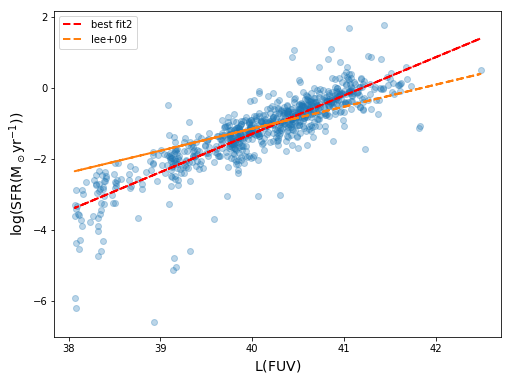

In [8]:
# "This relation is the result of a linear least squares fit of SFR(FUV),
# where L(FUV) has been corrected for internal dust extinction,
# as a function of SFR(Hα), which has not been dust corrected."

xarr = corr_tbl['obs_lumin'].data+nii_ha_corr_factor+filt_corr_factor # L(Hα), not dust corrected
yarr = log_SFR_UV_dustcorr # SFR(FUV) corrected for internal dust extinction

params2, covar2 = curve_fit(line2, xarr, yarr, p0=[0.62,-0.47])
print params2

plt.plot(xarr, yarr, 'o', alpha=0.3)
plt.gcf().set_size_inches(8,6)

plt.plot(xarr, line2(xarr, *params2), 'r--', lw=2, label='best fit2')
plt.plot(xarr, lee09_eqn10(xarr), '--', lw=2, label='lee+09')
plt.xlabel(r'$\rm L(FUV)$', size=14)
plt.ylabel(r'$\rm \log (SFR (M_\odot yr^{-1}))$', size=14)
plt.legend()
plt.show()

In [ ]:
# with 7.9e-42:
# [1.07936054 0.1091094 ]

### fig5

In [36]:
from plot_mainseq_UV_Ha_comparison import get_UV_SFR
log_SFR_HA_dustcorr = obs_sfrs+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor
log_SFR_UV_dustcorr = get_UV_SFR(corr_tbl) + 0.4*A_UV
log_SFR_ratio_dustcorr = log_SFR_HA_dustcorr - log_SFR_UV_dustcorr

In [80]:
from scipy.optimize import curve_fit

salpeter_to_chabrier = np.log10(7.9/4.55)
xlims0 = [min(log_SFR_HA_dustcorr)-0.2, max(log_SFR_HA_dustcorr)+0.2]

In [111]:
jlee_xarr = np.array([0.5,-0.25,-0.75,-1.25,-1.75,
    -2.25,-2.75,-3.5,-4.5])
jlee_logSFR_ratio = np.array([-0.14,-0.09,-0.13,-0.13,
    -0.18,-0.27,-0.51,-0.55,-1.43])
jlee_logSFR_ratio_errs = np.array([.29,.2,.22,.22,.17,
    .22,.25,.57,.59])


xtmparr0 = np.linspace(min(jlee_xarr)-0.1, -1.5, 10)
xtmparr1 = np.linspace(-1.5, xlims0[1]+0.1, 10)
xtmparr0 -= salpeter_to_chabrier
xtmparr1 -= salpeter_to_chabrier
jlee_xarr -= salpeter_to_chabrier

turnover = min(xtmparr1)

In [112]:
yesz_ii = np.where((corr_tbl['zspec0'].data > 0.) & (corr_tbl['zspec0'].data < 9.))[0]
low_SFRHA_ii = np.where(log_SFR_HA_dustcorr[yesz_ii] <= turnover)[0]
high_SFRHA_ii = np.where(log_SFR_HA_dustcorr[yesz_ii] >= turnover)[0]
const = np.mean(log_SFR_ratio_dustcorr[yesz_ii][high_SFRHA_ii])
def line(x, m):
    return m*(x-turnover)+const
print 'log(SFR(Ha)/SFR(FUV)) = %.3f'%const, 'for log(SFR(Ha)) > -1.5'
coeffs, covar = curve_fit(line, log_SFR_HA_dustcorr[yesz_ii][low_SFRHA_ii],
                          log_SFR_ratio_dustcorr[yesz_ii][low_SFRHA_ii])
print 'log(SFR(Ha)/SFR(FUV)) = %.3f log(SFR(Ha)) + %.3f'%(coeffs[0], const-m*turnover), 'for log(SFR(Ha)) < -1.5'

log(SFR(Ha)/SFR(FUV)) = -0.166 for log(SFR(Ha)) > -1.5
log(SFR(Ha)/SFR(FUV)) = 0.275 log(SFR(Ha)) + 0.133 for log(SFR(Ha)) < -1.5


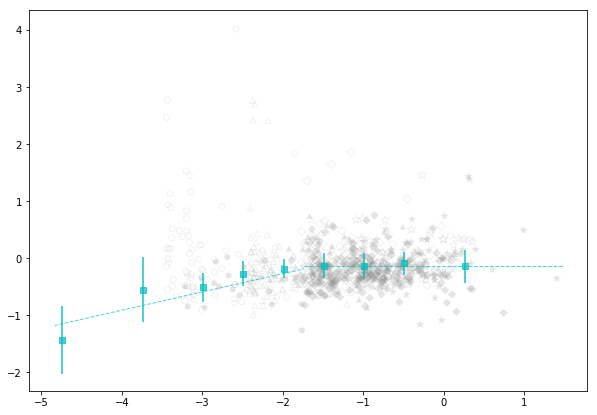

In [113]:
from plot_mainseq_UV_Ha_comparison import plot_zz_shapes_filled
f, ax = plt.subplots()
ax = plot_zz_shapes_filled(ax, log_SFR_HA_dustcorr, log_SFR_ratio_dustcorr, corr_tbl, color='gray')

# ax.plot(xtmparr0, line(xtmparr0, *coeffs), 'k--')
# ax.plot(xtmparr1, np.array([const]*len(xtmparr1)), 'k--')

ax.plot(jlee_xarr, jlee_logSFR_ratio, 'cs', alpha=0.7)
ax.errorbar(jlee_xarr, jlee_logSFR_ratio, fmt='none', ecolor='c', lw=2,
    yerr=jlee_logSFR_ratio_errs, alpha=0.7)
ax.plot(xtmparr0, 0.32*xtmparr0+0.37, 'c--', alpha=0.7,
    label='Lee+09: '+r'$0.32 \log(\rm SFR(H\alpha))+0.37$')
ax.plot(xtmparr1, np.array([-0.13]*len(xtmparr1)), 'c--', alpha=0.7,
    label='Lee+09: '+r'$-0.13$')

f.set_size_inches(10,7)
plt.show()

## applying FUV corrections to \Ha\ SFR

In [10]:
from plot_mainseq_UV_Ha_comparison import get_UV_SFR, get_LUV

In [13]:
# reading input files
fout  = asc.read(FULL_PATH+
    'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast'+fileend+'.fout',
    guess=False, Reader=asc.NoHeader)

corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]
print '### done reading input files'


# defining useful things
corrID = corr_tbl['ID'].data
corrzspec0 = corr_tbl['zspec0'].data
corrfilts = corr_tbl['filt'].data

color_arr = ['r', 'orange', 'g', 'b']
centr_filts = {'NB7':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
    'NB816':8152.0/HA - 1, 'NB921':9193.0/HA - 1, 'NB973':9749.0/HA - 1}


# getting SFR values
log_SFR_LUV = get_UV_SFR(corr_tbl)

LUV = np.zeros(len(corr_tbl))
for ff in ['NB7','NB816','NB921','NB973']:
    print ff

    filt_index_haii = np.array([x for x in range(len(corr_tbl)) if ff in
        corrfilts[x]])

    lnu = get_LUV(corrID, corrzspec0, centr_filts, filt_index_haii, ff)
    LUV[filt_index_haii] = lnu

log_SFR_UV = log_SFR_LUV + LUV
log_SFR_HA = corr_tbl['met_dep_sfr'].data

log_SFR_ratio = log_SFR_HA - log_SFR_UV
stlr_mass = corr_tbl['stlr_mass'].data
yesz_ii = np.where((corr_tbl['zspec0'].data > 0.) & (corr_tbl['zspec0'].data < 9.))[0]

### done reading input files
NB7
NB816
NB921
NB973


In [14]:
from scipy.optimize import curve_fit
def line(x, m, b):
    return m*x+b

coeffs, covar = curve_fit(line, log_SFR_HA[yesz_ii], log_SFR_ratio[yesz_ii])
m, b = coeffs[0], coeffs[1]
print m, b

0.17232015375759424 0.07128316191367734


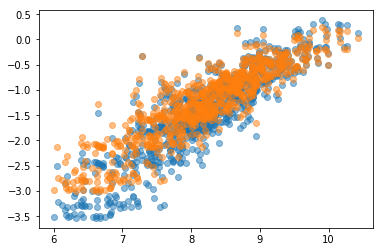

In [27]:
plt.plot(stlr_mass, log_SFR_HA, 'o', alpha=0.5)
# plt.plot(stlr_mass, (log_SFR_UV + b)/(1-m), 'o', alpha=0.5)
FUV_corrs = -(m*log_SFR_HA + b)
plt.plot(stlr_mass, log_SFR_HA + FUV_corrs, 'o', alpha=0.5)